#### Setup

In [ ]:
import librosa
import librosa.display
import torch
import torch.nn as nn
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import pickle
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# need device to instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
osx='windows'

## Loading Functions

In [ ]:
def load_data_iemo():

    # features and labels
    emotions = iemocap_metadata['emotion'].tolist()
    emotions = list(map(emotions_dict_iemo.get, emotions, emotions))

    # raw waveforms to augment later
    waveforms = []

    # genders
    genders = iemocap_metadata['gender'].tolist()
    genders = ['female' if x == 'F' else 'male' for x in genders]

    # types
    types = iemocap_metadata['method'].tolist()

    # progress counter
    file_count = 0
    for path in iemocap_metadata['path'].iteritems():
      audio_file = data_path_iemo + path[1]

      # get waveform from the sample
      waveform = get_waveforms(audio_file, sample_rate_iemocap, duration=9, offset=0)

      # store waveforms and labels
      waveforms.append(waveform)

      # keep track of data loader's progress
      file_count += 1
      print('\r'+f' Processed {file_count}/{10039} audio samples',end='')

    return waveforms, emotions, types, genders

In [ ]:
def load_data_rav():
    # features and labels
    emotions = []
    # raw waveforms to augment later
    waveforms = []
    # extra labels
    intensities, genders = [],[]
    # progress counter
    file_count = 0
    for file in glob.glob(data_path_rav):
        # get file name with labels
        file_name = os.path.basename(file)

        # get emotion label from the sample's file
        emotion = int(file_name.split("-")[2])

        #  move surprise to 0 for cleaner behaviour with PyTorch/0-indexing
        if emotion == 8: emotion = 0 # surprise is now at 0 index; other emotion indeces unchanged

        # can convert emotion label to emotion string if desired, but
        # training on number is better; better convert to emotion string after predictions are ready
        # emotion = emotions_dict[str(emotion)]

        # get other labels we might want
        intensity = emotion_attributes_rav[file_name.split("-")[3]]
        # even actors are female, odd are male
        if (int((file_name.split("-")[6]).split(".")[0]))%2==0: 
          gender = 'female' 
        else: 
          gender = 'male'

#         if emotion == 2:
#             continue
#         else:
        # get waveform from the sample
        waveform = get_waveforms(file, sample_rate_rav, duration=3, offset=0.5)

        # store waveforms and labels
        waveforms.append(waveform)
        emotions.append(emotion)
        intensities.append(intensity) # store intensity in case we wish to predict
        genders.append(gender) # store gender in case we wish to predict 

        file_count += 1
        # keep track of data loader's progress
        print('\r'+f' Processed {file_count}/{1440} audio samples',end='')
#         # change y_train and y_val labels: no target 2, but target 7.
#     emo_rav_look_up = {
#         3:2,
#         4:3,
#         5:4,
#         6:5,
#         7:6
#     }
#    emotions = [emo_rav_look_up.get(item,item)  for item in emotions]
    return waveforms, emotions, intensities, genders

## Loading Data

In [ ]:
if osx == 'mac':
    data_path_rav = '/Users/philipweinmann/Meine Ablage/5-Code-Projects/IdeaProjects/1-THI/4-NLP/Speech-Emotion-Recognition/datasets/ravdess/audio_speech_actors_01-24/Actor_*/*.wav'
    data_path_iemo = '/Users/philipweinmann/Meine Ablage/5-Code-Projects/IdeaProjects/1-THI/4-NLP/Speech-Emotion-Recognition/datasets/iemocap/'
    iemocap_metadata = pd.read_csv('/Users/philipweinmann/Meine Ablage/5-Code-Projects/IdeaProjects/1-THI/4-NLP/Speech-Emotion-Recognition/datasets/iemocap/iemocap_full_dataset.csv', sep=';')
elif osx == 'windows':
    data_path_rav = 'G:\\Meine Ablage\\5-Code-Projects\\IdeaProjects\\1-THI\\4-NLP\\Speech-Emotion-Recognition\datasets\\ravdess\\audio_speech_actors_01-24\\Actor_*\\*.wav'
    data_path_iemo = 'G:\\Meine Ablage\\5-Code-Projects\\IdeaProjects\\1-THI\\4-NLP\\Speech-Emotion-Recognition\datasets\\iemocap\\'
    iemocap_metadata = pd.read_csv('G:\\Meine Ablage\\5-Code-Projects\\IdeaProjects\\1-THI\\4-NLP\\Speech-Emotion-Recognition\datasets\\iemocap\\iemocap_full_dataset.csv', sep=';')

In [ ]:
emotions_dict_rav ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}
emotion_attributes_rav = {
    '01': 'normal',
    '02': 'strong'
}

In [ ]:
emotions_dict_iemo ={
    'sur': 0,
    'neu': 1,
    'oth': 2,
    'hap': 3,
    'sad': 4,
    'ang': 5,
    'fea': 6,
    'dis': 7,
    'fru': 8,
    'exc': 9,
    'xxx': 10
}

In [ ]:
sample_rate_iemocap = 16000
sample_rate_rav = 48000

## Feature Extraction (MFCC)

In [ ]:
# Mel Spectrograms are not directly used as a feature in this model
# Mel Spectrograms are used in calculating MFCCs, which are a higher-level representation of pitch transition
# MFCCs work better - left the mel spectrogram function here in case anyone wants to experiment
def feature_melspectrogram(
    waveform, 
    sample_rate,
    fft = 1024,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):
    
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform, 
        sr=sample_rate, 
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2)
    
    # convert from power (amplitude**2) to decibels
    # necessary for network to learn - doesn't converge with raw power spectrograms 
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    
    return melspectrogram

In [ ]:
def feature_mfcc(
    waveform, 
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    #hop=256, # increases # of time steps; was not helpful
    mels=128
    ):

    # Compute the MFCCs for all STFT frames 
    # 40 mel filterbanks (n_mfcc) = 40 coefficients
    mfc_coefficients=librosa.feature.mfcc(
        y=waveform, 
        sr=sample_rate, 
        n_mfcc=n_mfcc,
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        #hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2
        ) 

    return mfc_coefficients

In [ ]:
def get_features(waveforms, features, sample_rate):

    # initialize counter to track progress
    file_count = 0

    # process each waveform individually to get its MFCCs
    for waveform in waveforms:
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)
        file_count += 1
        # print progress 
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')
    
    # return all features from list of waveforms
    return features

In [ ]:
def get_waveforms(file, sample_rate, duration,offset):
    
    # load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns
    waveform, _ = librosa.load(file, duration=duration, offset=offset, sr=sample_rate)
    
    # make sure waveform vectors are homogenous by defining explicitly
    waveform_homo = np.zeros((int(sample_rate*duration,)))
    waveform_homo[:len(waveform)] = waveform

    # return a single file's waveform                                      
    return waveform_homo

## Extract Features Ravdess & Iemocap
-process each file in the dataset and extract its features.
-return the waveforms and the labels (from the metafile of the iemocap dataset. 
-return the raw waveforms because we're going to do some extra processing.

In [ ]:
waveforms_rav, emotions_rav, intensities_rav, genders_rav = [],[],[],[]
waveforms_rav, emotions_rav, intensities_rav, genders_rav = load_data_rav()

 Processed 1440/1440 audio samples

In [ ]:
waveforms_iemo, emotions_iemo, types, genders_iemo = [],[],[],[]
waveforms_iemo, emotions_iemo, types, genders_iemo = load_data_iemo()

 Processed 10039/10039 audio samples

## Check existing Target Labels and select 4 of them 

In [ ]:
unique_rav, counts_rav = np.unique(np.array(emotions_rav), return_counts=True)
unique_iemo, counts_iemo = np.unique(np.array(emotions_iemo), return_counts=True)
emo_rav = [v for k,v in emotions_dict_rav.items()]
emo_iemo = [k for k,v in emotions_dict_iemo.items()]

In [ ]:
df_rav = pd.DataFrame({'Emotion Index': unique_rav, 'Emotion Count Ravdess': counts_rav, 'Emotion Ravdess': np.array(emo_rav)})
df_rav = df_rav.set_index('Emotion Index')
df_iemo = pd.DataFrame({'Emotion Index': unique_iemo, 'Emotion Count Iemocap': counts_iemo, 'Emotion Iemocap': np.array(emo_iemo)})
df_iemo = df_iemo.set_index('Emotion Index')

In [ ]:
pd.concat([df_rav, df_iemo], axis=1)

,Emotion Count Ravdess,Emotion Ravdess,Emotion Count Iemocap,Emotion Iemocap
Emotion Index,,,,
0,192.0,surprised,107,sur
1,96.0,neutral,1708,neu
2,192.0,calm,3,oth
3,192.0,happy,595,hap
4,192.0,sad,1084,sad
5,192.0,angry,1103,ang
6,192.0,fearful,40,fea
7,192.0,disgust,2,dis
8,NaN,NaN,1849,fru


#### To Do:

- keep following emotions: neutral 1, happy 3, sad 4, angry 5


- Iemocap Data: -  remove targets with index:0, 2, 6, 7, 8, 9, 10

- Ravdess Data: - remove targets with indes: 0, 2, 6, 7


## Remove unwanted emotion data from datasets

In [ ]:
def remove_emo_by_index(emotion_index_list):
    rav_indices = []
    iemo_indices = []
    # Get Indices from target lists that need to be removed
    for ind, x in enumerate(emotions_rav):
        if x not in emotion_index_list:
            rav_indices.append(ind)
            
    for ind, x in enumerate(emotions_iemo):
        if x not in emotion_index_list:
            iemo_indices.append(ind)
    
    results = []
    # removing targets, features, .. by index lists
    # Ravdess Data
    waveforms_rav_new = [waveforms_rav[i] for i in rav_indices]
    emotions_rav_new = [emotions_rav[i] for i in rav_indices]
    intensities_rav_new = [intensities_rav[i] for i in rav_indices]
    genders_rav_new = [genders_rav[i] for i in rav_indices]

    
    # Iemocap Data
    waveforms_iemo_new = [waveforms_iemo[i] for i in iemo_indices]
    emotions_iemo_new = [emotions_iemo[i] for i in iemo_indices]
    types_new = [types[i] for i in iemo_indices]
    genders_iemo_new = [genders_iemo[i] for i in iemo_indices]
    
    emotions_rav_new, emotions_iemo_new = emo_normalize_index(emotions_rav_new, emotions_iemo_new)
    
    results.append(waveforms_rav_new)
    results.append(emotions_rav_new)
    results.append(intensities_rav_new)
    results.append(genders_rav_new)
    
    results.append(waveforms_iemo_new)
    results.append(emotions_iemo_new)
    results.append(types_new)
    results.append(genders_iemo_new)
    
    
    return results

In [ ]:
def emo_normalize_index(y_rav, y_iemo):
    lod = {1:0, 
           3:1, 
           4:2, 
           5:3}
    
    y_rav_out = [lod.get(x) for x in y_rav]
    y_iemo_out = [lod.get(x) for x in y_iemo]
    return y_rav_out, y_iemo_out    

In [ ]:
results = remove_emo_by_index([0, 2, 6, 7, 8, 9, 10])

## Check extracted audio waveforms and labels:


In [ ]:
waveforms_rav = results[0]
emotions_rav = results[1]
intensities_rav = results[2]
genders_rav = results[3]

waveforms_iemo = results[4]
emotions_iemo = results[5]
types = results[6]
genders_iemo = results[7]

In [ ]:
print(f'Waveforms Ravdess set: {len(waveforms_rav)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms_rav[0])}')
print(f'Emotions Ravdess set: {len(emotions_rav)} sample labels')

Waveforms Ravdess set: 672 samples
Waveform signal length: 144000
Emotions Ravdess set: 672 sample labels


In [ ]:
print(f'Waveforms Iemocap set: {len(waveforms_iemo)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms_iemo[0])}')
print(f'Emotions Iemocap set: {len(emotions_iemo)} sample labels')

Waveforms Iemocap set: 4490 samples
Waveform signal length: 144000
Emotions Iemocap set: 4490 sample labels


## Split into Train/Validation/Test Sets
We'll use an 80/10/10 train/validation/test split when we train and test on the same dataset.


Since we are trying to compare models that have been trained on different datasets, based on different test sets, we need to be aware of our different train, test and validation sets

- Training-, Test- and Validation Datasets for the Model that has been **trained and tested on Ravdess** will have additional  **_rav_only** in variable names

- Training-, Test- and Validation Datasets for the Model that has been **trained and tested on Iemocap** will have additional  **_iemo_only** in variable names

- Training-, Test- and Validation Datasets for the Model that has been **trained on Ravdess and tested on Iemocap** will have additional  **iemo_test** in variable names

- Training-, Test- and Validation Datasets for the Model that has been **trained on Iemocap and tested on Ravdess** will have additional  **rav_test** in variable names

In [ ]:
### RAV ONLY DATA ###

# First split into train and remaining
X_train_rav_only, X_rem_rav_only, y_train_rav_only, y_rem_rav_only = train_test_split(waveforms_rav, emotions_rav, test_size=0.2, random_state=None, shuffle=True, stratify=None)

# Second split into test and valid
X_valid_rav_only, X_test_rav_only, y_valid_rav_only, y_test_rav_only = train_test_split(X_rem_rav_only, y_rem_rav_only, test_size=0.5, random_state=None, shuffle=True, stratify=None)


X_train_rav_only = np.array(X_train_rav_only)
y_train_rav_only = np.array(y_train_rav_only)

X_valid_rav_only = np.array(X_valid_rav_only)
y_valid_rav_only = np.array(y_valid_rav_only)

X_test_rav_only = np.array(X_test_rav_only)
y_test_rav_only = np.array(y_test_rav_only)

In [ ]:
### IEMO ONLY DATA ###

# First split into train and remaining
X_train_iemo_only, X_rem_iemo_only, y_train_iemo_only, y_rem_iemo_only = train_test_split(waveforms_iemo, emotions_iemo, test_size=0.2, random_state=None, shuffle=True, stratify=None)

# Second split into test and valid
X_valid_iemo_only, X_test_iemo_only, y_valid_iemo_only, y_test_iemo_only = train_test_split(X_rem_iemo_only, y_rem_iemo_only, test_size=0.5, random_state=None, shuffle=True, stratify=None)


X_train_iemo_only = np.array(X_train_iemo_only)
y_train_iemo_only = np.array(y_train_iemo_only)

X_valid_iemo_only = np.array(X_valid_iemo_only)
y_valid_iemo_only = np.array(y_valid_iemo_only)

X_test_iemo_only = np.array(X_test_iemo_only)
y_test_iemo_only = np.array(y_test_iemo_only)

In [ ]:
### IEMO TEST DATA ###

# Ravdess dataset doesnt need to be splitted
X_train_iemo_test = waveforms_rav
y_train_iemo_test = emotions_rav

# Iemocap dataset needs to be splitted, because we test and validate on it
X_test_iemo_test, X_valid_iemo_test, y_test_iemo_test, y_valid_iemo_test = train_test_split(waveforms_iemo, emotions_iemo, test_size=0.1, random_state=None, shuffle=True, stratify=None)

X_train_iemo_test = np.array(X_train_iemo_test)
y_train_iemo_test = np.array(y_train_iemo_test)

X_valid_iemo_test = np.array(X_valid_iemo_test)
y_valid_iemo_test = np.array(y_valid_iemo_test)

X_test_iemo_test = np.array(X_test_iemo_test)
y_test_iemo_test = np.array(y_test_iemo_test)

In [ ]:
### Rav TEST DATA ###

# Iemocap dataset doesnt need to be splitted
X_train_rav_test = waveforms_iemo
y_train_rav_test = emotions_iemo

# Ravdess dataset needs to be splitted, because we test and validate on it
X_test_rav_test, X_valid_rav_test, y_test_rav_test, y_valid_rav_test = train_test_split(waveforms_rav, emotions_rav, test_size=0.1, random_state=None, shuffle=True, stratify=None)



X_train_rav_test = np.array(X_train_rav_test)
y_train_rav_test = np.array(y_train_rav_test)

X_valid_rav_test = np.array(X_valid_rav_test)
y_valid_rav_test = np.array(y_valid_rav_test)

X_test_rav_test = np.array(X_test_rav_test)
y_test_rav_test = np.array(y_test_rav_test)

In [ ]:
# check shape of each set

print(f'Training waveforms RAV ONLY MODEL:{X_train_rav_only.shape}, y_train:{y_train_rav_only.shape}')
print(f'Vallidation waveforms RAV ONLY MODEL:{X_valid_rav_only.shape}, y_valid:{y_valid_rav_only.shape}')
print(f'Test waveforms RAV ONLY MODEL:{X_test_rav_only.shape}, y_valid:{y_test_rav_only.shape}')
print()
print(f'Training waveforms IEMO ONLY MODEL:{X_train_iemo_only.shape}, y_train:{y_train_iemo_only.shape}')
print(f'Vallidation waveforms IEMO ONLY MODEL:{X_valid_iemo_only.shape}, y_valid:{y_valid_iemo_only.shape}')
print(f'Test waveforms IEMO ONLY MODEL:{X_test_iemo_only.shape}, y_valid:{y_test_iemo_only.shape}')
print()
print(f'Training waveforms IEMO TEST MODEL:{X_train_iemo_test.shape}, y_train:{y_train_iemo_test.shape}')
print(f'Vallidation waveforms IEMO TEST MODEL:{X_valid_iemo_test.shape}, y_valid:{y_valid_iemo_test.shape}')
print(f'Test waveforms IEMO TEST MODEL:{X_test_iemo_test.shape}, y_valid:{y_test_iemo_test.shape}')
print()
print(f'Training waveforms RAV TEST MODEL:{X_train_rav_test.shape}, y_train:{y_train_rav_test.shape}')
print(f'Vallidation waveforms RAV TEST MODEL:{X_valid_rav_test.shape}, y_valid:{y_valid_rav_test.shape}')
print(f'Test waveforms RAV TEST MODEL:{X_test_rav_test.shape}, y_valid:{y_test_rav_test.shape}')

Training waveforms RAV ONLY MODEL:(537, 144000), y_train:(537,)
Vallidation waveforms RAV ONLY MODEL:(67, 144000), y_valid:(67,)
Test waveforms RAV ONLY MODEL:(68, 144000), y_valid:(68,)

Training waveforms IEMO ONLY MODEL:(3592, 144000), y_train:(3592,)
Vallidation waveforms IEMO ONLY MODEL:(449, 144000), y_valid:(449,)
Test waveforms IEMO ONLY MODEL:(449, 144000), y_valid:(449,)

Training waveforms IEMO TEST MODEL:(672, 144000), y_train:(672,)
Vallidation waveforms IEMO TEST MODEL:(449, 144000), y_valid:(449,)
Test waveforms IEMO TEST MODEL:(4041, 144000), y_valid:(4041,)

Training waveforms RAV TEST MODEL:(4490, 144000), y_train:(4490,)
Vallidation waveforms RAV TEST MODEL:(68, 144000), y_valid:(68,)
Test waveforms RAV TEST MODEL:(604, 144000), y_valid:(604,)


## Extract Features 


In [ ]:
def extract_features(X_train, X_valid, X_test, sr):
    features_train, features_valid, features_test = [],[],[]
    
    print('Train waveforms:') # get training set features 
    features_train = get_features(X_train, features_train, sr)
    
    print('\n\nValidation waveforms:') # get validation set features
    features_valid = get_features(X_valid, features_valid, sr)
    
    print('\n\nTest waveforms:') # get test set features 
    features_test = get_features(X_test, features_test, sr)
    
    print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
    print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')
    
    return features_train, features_valid, features_test

In [ ]:
def extract_features_different_datasets(X_train, X_valid, X_test, sr1, sr2):
    features_train, features_valid, features_test = [],[],[]
    
    print('Train waveforms:') # get training set features 
    features_train = get_features(X_train, features_train, sr1)
    
    print('\n\nValidation waveforms:') # get validation set features
    features_valid = get_features(X_valid, features_valid, sr1)
    
    print('\n\nTest waveforms:') # get test set features 
    features_test = get_features(X_test, features_test, sr2)
    
    print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
    print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')
    
    return features_train, features_valid, features_test

In [ ]:
## Rav Only Data
features_train_rav_only, features_valid_rav_only, features_test_rav_only = extract_features(X_train_rav_only, X_valid_rav_only, X_test_rav_only, sample_rate_rav)

Train waveforms:
 Processed 537/537 waveforms

Validation waveforms:
 Processed 67/67 waveforms

Test waveforms:
 Processed 68/68 waveforms

Features set: 672 total, 537 train, 67 validation, 68 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


In [ ]:
## Iemo Only Data
features_train_iemo_only, features_valid_iemo_only, features_test_iemo_only = extract_features(X_train_iemo_only, X_valid_iemo_only, X_test_iemo_only, sample_rate_iemocap)

Train waveforms:
 Processed 3592/3592 waveforms

Validation waveforms:
 Processed 449/449 waveforms

Test waveforms:
 Processed 449/449 waveforms

Features set: 4490 total, 3592 train, 449 validation, 449 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


In [ ]:
## Iemo Test Data
features_train_iemo_test, features_valid_iemo_test, features_test_iemo_test = extract_features_different_datasets(X_train_iemo_test, X_valid_iemo_test, X_test_iemo_test, sample_rate_rav, sample_rate_iemocap)

Train waveforms:
 Processed 672/672 waveforms

Validation waveforms:
 Processed 449/449 waveforms

Test waveforms:
 Processed 4041/4041 waveforms

Features set: 5162 total, 672 train, 449 validation, 4041 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


In [ ]:
## Rav Test Data
features_train_rav_test, features_valid_rav_test, features_test_rav_test = extract_features_different_datasets(X_train_rav_test, X_valid_rav_test, X_test_rav_test, sample_rate_iemocap, sample_rate_rav)

Train waveforms:
 Processed 4490/4490 waveforms

Validation waveforms:
 Processed 68/68 waveforms

Test waveforms:
 Processed 604/604 waveforms

Features set: 5162 total, 4490 train, 68 validation, 604 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


## Features and Data

In [ ]:
X = [X_train_rav_only, X_valid_rav_only, X_test_rav_only,
     X_train_iemo_only, X_valid_iemo_only, X_test_iemo_only,
     X_train_iemo_test, X_valid_iemo_test, X_test_iemo_test,
     X_train_rav_test, X_valid_rav_test, X_test_rav_test]

y = [y_train_rav_only, y_valid_rav_only, y_test_rav_only,
     y_train_iemo_only, y_valid_iemo_only, y_test_iemo_only,
     y_train_iemo_test, y_valid_iemo_test, y_test_iemo_test,
     y_train_rav_test, y_valid_rav_test, y_test_rav_test]

In [ ]:
data = [X,y]

In [ ]:
features = [features_train_rav_only, features_valid_rav_only, 
            features_test_rav_only, features_train_iemo_only, 
            features_valid_iemo_only, features_test_iemo_only, 
            features_train_iemo_test, features_valid_iemo_test, 
            features_test_iemo_test, features_train_rav_test, 
            features_valid_rav_test, features_test_rav_test ]

In [ ]:
## FORMATS AT THIS POINT

## data = [X, y]
# X = [X_train_rav_only, X_valid_rav_only, X_test_rav_only,
#      X_train_iemo_only, X_valid_iemo_only, X_test_iemo_only,
#      X_train_iemo_test, X_valid_iemo_test, X_test_iemo_test,
#      X_train_rav_test, X_valid_rav_test, X_test_rav_test]

#  y = [y_train_rav_only, y_valid_rav_only, y_test_rav_only,
#      y_train_iemo_only, y_valid_iemo_only, y_test_iemo_only,
#      y_train_iemo_test, y_valid_iemo_test, y_test_iemo_test,
#      y_train_rav_test, y_valid_rav_test, y_test_rav_only],


# features = [features_train_rav_only, features_valid_rav_only, 
#             features_test_rav_only, features_train_iemo_only, 
#             features_valid_iemo_only, features_test_iemo_only, 
#             features_train_iemo_test, features_valid_iemo_test, 
#             features_test_iemo_test, features_train_rav_test, 
#             features_valid_rav_test, features_test_rav_test ]

## Format Data into Tensor Ready 4D Arrays
We don't have a colour channel in our MFCC feature array of dim (#samples, #MFC coefficients, time steps). **We have an analog of a black and white image: instead of 3 colour channels, we have 1 signal intensity channel: magnitude of each of 40 mel frequency coefficients at time t.**

**We need an input channel dim to expand to output channels using CNN filters. We create a dummy channel dim to expand features into 2D-CNN-ready 4D tensor format: N x C x H x W.**

In [ ]:
def make_dummy_channel(X, y):
    # need to make dummy input channel for CNN input feature tensor
    X_out = np.expand_dims(X, 1)
   
    # convert emotion labels from list back to numpy arrays for PyTorch to work with 
    y_out = np.array(y)
    return X_out, y_out

In [ ]:
a = []
b = [] 

for i in range(len(y)):
    x_out, y_out = make_dummy_channel(features[i], y[i])
    a.append(x_out)
    b.append(y_out)
    
X = copy.deepcopy(a)
y = copy.deepcopy(b)

## Printing Shapes to make sure we have 4D arrays ready

In [ ]:
X_train_rav_only = X[0]
X_valid_rav_only = X[1]
X_test_rav_only = X[2]
X_train_iemo_only = X[3]
X_valid_iemo_only = X[4]
X_test_iemo_only = X[5]
X_train_iemo_test = X[6]
X_valid_iemo_test = X[7]
X_test_iemo_test = X[8]
X_train_rav_test = X[9]
X_valid_rav_test = X[10]
X_test_rav_test = X[11]

In [ ]:
y_train_rav_only = y[0]
y_valid_rav_only = y[1]
y_test_rav_only = y[2]
y_train_iemo_only = y[3]
y_valid_iemo_only = y[4]
y_test_iemo_only = y[5]
y_train_iemo_test = y[6]
y_valid_iemo_test = y[7]
y_test_iemo_test = y[8]
y_train_rav_test = y[9]
y_valid_rav_test = y[10]
y_test_rav_test = y[11]

In [ ]:
for data, label in zip(X,y):
    print(f'Shape of 4D feature array for input tensor: {data.shape}')
    print(f'Shape of emotion labels: {label.shape}')

Shape of 4D feature array for input tensor: (537, 1, 40, 282)
Shape of emotion labels: (537,)
Shape of 4D feature array for input tensor: (67, 1, 40, 282)
Shape of emotion labels: (67,)
Shape of 4D feature array for input tensor: (68, 1, 40, 282)
Shape of emotion labels: (68,)
Shape of 4D feature array for input tensor: (3592, 1, 40, 282)
Shape of emotion labels: (3592,)
Shape of 4D feature array for input tensor: (449, 1, 40, 282)
Shape of emotion labels: (449,)
Shape of 4D feature array for input tensor: (449, 1, 40, 282)
Shape of emotion labels: (449,)
Shape of 4D feature array for input tensor: (672, 1, 40, 282)
Shape of emotion labels: (672,)
Shape of 4D feature array for input tensor: (449, 1, 40, 282)
Shape of emotion labels: (449,)
Shape of 4D feature array for input tensor: (4041, 1, 40, 282)
Shape of emotion labels: (4041,)
Shape of 4D feature array for input tensor: (4490, 1, 40, 282)
Shape of emotion labels: (4490,)
Shape of 4D feature array for input tensor: (68, 1, 40, 28

## Feature Scaling
Scaling will drastically decrease the length of time the model needs to train to convergence - it will have easier computations to perform on smaller magnitudes. **For reference, scaling reduces the time to convergence from about 500 to 200 epochs for this model.**

**Standard Scaling makes the most sense because we have features whose target distribution we don't know.** When I performed classification on this dataset with an MLP classifier standard scaling was best across a variety of conditions and features.


In [ ]:
def scale(X, label):
    scaler = StandardScaler()
    
    #### Scale the data ####
    # store shape so we can transform it back 
    
    N,C,H,W = X.shape
    # Reshape to 1D because StandardScaler operates on a 1D array
    # tell numpy to infer shape of 1D array with '-1' argument
    
    X = np.reshape(X, (N,-1)) 
    X = scaler.fit_transform(X)
    
    # Transform back to NxCxHxW 4D tensor format
    X = np.reshape(X, (N,C,H,W))

    # check shape of each set again
    print(f'X scaled:{X.shape}, y:{label.shape}')
    return X

In [ ]:
tmp = []
for idx, x in enumerate(X):
    x_out = scale(x, y[idx])
    tmp.append(x_out)
X = copy.deepcopy(tmp)

X scaled:(537, 1, 40, 282), y:(537,)
X scaled:(67, 1, 40, 282), y:(67,)
X scaled:(68, 1, 40, 282), y:(68,)
X scaled:(3592, 1, 40, 282), y:(3592,)
X scaled:(449, 1, 40, 282), y:(449,)
X scaled:(449, 1, 40, 282), y:(449,)
X scaled:(672, 1, 40, 282), y:(672,)
X scaled:(449, 1, 40, 282), y:(449,)
X scaled:(4041, 1, 40, 282), y:(4041,)
X scaled:(4490, 1, 40, 282), y:(4490,)
X scaled:(68, 1, 40, 282), y:(68,)
X scaled:(604, 1, 40, 282), y:(604,)


## Checkpoint: Saving Data 

In [ ]:
del features, features_train_rav_only, features_valid_rav_only, features_test_rav_only, features_train_iemo_only
del features_valid_iemo_only, features_test_iemo_only, features_train_iemo_test, features_valid_iemo_test, tmp
del features_test_iemo_test, features_train_rav_test, features_valid_rav_test, features_test_rav_test, a, b

In [ ]:
### Save
data = [X, y]
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
### Load
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)
X, y = data

X_train_rav_only = X[0]
X_valid_rav_only = X[1]
X_test_rav_only = X[2]
X_train_iemo_only = X[3]
X_valid_iemo_only = X[4]
X_test_iemo_only = X[5]
X_train_iemo_test = X[6]
X_valid_iemo_test = X[7]
X_test_iemo_test = X[8]
X_train_rav_test = X[9]
X_valid_rav_test = X[10]
X_test_rav_test = X[11]

y_train_rav_only = y[0]
y_valid_rav_only = y[1]
y_test_rav_only = y[2]
y_train_iemo_only = y[3]
y_valid_iemo_only = y[4]
y_test_iemo_only = y[5]
y_train_iemo_test = y[6]
y_valid_iemo_test = y[7]
y_test_iemo_test = y[8]
y_train_rav_test = y[9]
y_valid_rav_test = y[10]
y_test_rav_test = y[11]

# Build Model Architecture and Define Forward Pass

In [ ]:
#change nn.sequential to take dict to make more readable 

class parallel_all_you_want(nn.Module):
    def __init__(self,num_emotions):
        super().__init__() 
        
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
       
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, # input feature (frequency) dim after maxpooling 40*282 -> 40*70 (MFC*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 40-->512--->40
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
      
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock2 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 8 logits 
        # Each full convolution block outputs (64*1*8) embedding flattened to dim 512 1D array 
        # Full transformer block outputs 40*70 feature map, which we time-avg to dim 40 1D array
        # 512*2+40 == 1064 input features --> 4  output emotions 
        self.fc1_linear = nn.Linear(512*2+40,num_emotions) 
        
        ### Softmax layer for the 8 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
        
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 
        
         
        ########## 4-encoder-layer Transformer block w/ 40-->512-->40 feedfwd network ##############
        # maxpool input feature map: 1*40*282 w/ 1*4 kernel --> 1*40*70
        x_maxpool = self.transformer_maxpool(x)

        # remove channel dim: 1*40*70 --> 40*70
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        
        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1) 
        
        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)
        
        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 2x40 (MFCC embedding*time) feature map, take mean of columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40
        
        ############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)  

        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       

## Analyzing The Flow of Tensors Through the Network

In [ ]:
# instantiate model for 8 emotions and move to GPU 

num_labels = len(list(np.unique(emotions_rav)))

model = parallel_all_you_want(num_labels).to(device)

# include input feature map dims in call to summary()



# include input feature map dims in call to summary()
summary(model, input_size=(1,40,282))


Layer (type:depth-idx)                        Param #
├─MaxPool2d: 1-1                              --
├─TransformerEncoder: 1-2                     --
|    └─ModuleList: 2-1                        --
|    |    └─TransformerEncoderLayer: 3-1      48,232
|    |    └─TransformerEncoderLayer: 3-2      48,232
|    |    └─TransformerEncoderLayer: 3-3      48,232
|    |    └─TransformerEncoderLayer: 3-4      48,232
├─Sequential: 1-3                             --
|    └─Conv2d: 2-2                            160
|    └─BatchNorm2d: 2-3                       32
|    └─ReLU: 2-4                              --
|    └─MaxPool2d: 2-5                         --
|    └─Dropout: 2-6                           --
|    └─Conv2d: 2-7                            4,640
|    └─BatchNorm2d: 2-8                       64
|    └─ReLU: 2-9                              --
|    └─MaxPool2d: 2-10                        --
|    └─Dropout: 2-11                          --
|    └─Conv2d: 2-12                         

Layer (type:depth-idx)                        Param #
├─MaxPool2d: 1-1                              --
├─TransformerEncoder: 1-2                     --
|    └─ModuleList: 2-1                        --
|    |    └─TransformerEncoderLayer: 3-1      48,232
|    |    └─TransformerEncoderLayer: 3-2      48,232
|    |    └─TransformerEncoderLayer: 3-3      48,232
|    |    └─TransformerEncoderLayer: 3-4      48,232
├─Sequential: 1-3                             --
|    └─Conv2d: 2-2                            160
|    └─BatchNorm2d: 2-3                       32
|    └─ReLU: 2-4                              --
|    └─MaxPool2d: 2-5                         --
|    └─Dropout: 2-6                           --
|    └─Conv2d: 2-7                            4,640
|    └─BatchNorm2d: 2-8                       64
|    └─ReLU: 2-9                              --
|    └─MaxPool2d: 2-10                        --
|    └─Dropout: 2-11                          --
|    └─Conv2d: 2-12                         

# Training

## Define Training Step

In [ ]:
# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    
    # define the training step of the training phase
    def train_step(X,Y):
        
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 

        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

## Define Validation Step

Define a function to return a single validation step on the 10% X,y tensor pair to get an idea of our model's generalizibiliy as it trains so we know whether and when to stop it and tune hyperparameters. **Make sure we _do not_ update network parameters during validation by setting model to validation mode. Do not waste resources computing gradients in validation phase by setting torch.no_grad().**

In [ ]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

# Make Checkpoint Functions
It's a good idea to save checkpoints of the model state after good epochs when the validation loss dropped.

In [ ]:
def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

## Training Loops

In [ ]:
# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):
        
        # set model to train phase
        model.train()         
        
        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size) 
        
        # shuffle the training set for each epoch:
        X_train = X_train[train_indices,:,:,:] 
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate 
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        
        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):
            
            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch 
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size) 
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start 
            
            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:] 
            # get training minibatch labels 
            Y = Y_train[batch_start:batch_end] 

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            
            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')
        
        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
                  
        # Save checkpoint of the model
        if osx == 'mac':
            checkpoint_filename = 'checkpoints/parallel_all_you_wantFINAL-{:03d}.pkl'.format(epoch)
        elif osx == 'windows':
            checkpoint_filename = 'checkpoints\\parallel_all_you_wantFINAL-{:03d}.pkl'.format(epoch)

        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        
        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')


In [ ]:
# define loss function; CrossEntropyLoss() fairly standard for multiclass problems 
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

## MODEL 1

In [ ]:
## MODEL 1 RAVDESS ONLY

# get training set size to calculate # iterations and minibatch indices
train_size = X_train_rav_only.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=num_labels).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

cuda selected
Number of trainable params:  244228


In [ ]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 300

# train it!
train(optimizer, model, num_epochs, X_train_rav_only, y_train_rav_only, X_valid_rav_only, y_valid_rav_only)

Epoch 0: iteration 15/16
Epoch 0 --- loss:5.267, Epoch accuracy:32.40%, Validation loss:1.881, Validation accuracy:40.30%
Epoch 1: iteration 15/16
Epoch 1 --- loss:2.724, Epoch accuracy:34.82%, Validation loss:1.627, Validation accuracy:46.27%
Epoch 2: iteration 15/16
Epoch 2 --- loss:1.862, Epoch accuracy:38.36%, Validation loss:1.312, Validation accuracy:47.76%
Epoch 3: iteration 15/16
Epoch 3 --- loss:1.214, Epoch accuracy:48.04%, Validation loss:1.151, Validation accuracy:49.25%
Epoch 4: iteration 15/16
Epoch 4 --- loss:1.170, Epoch accuracy:47.86%, Validation loss:1.195, Validation accuracy:49.25%
Epoch 5: iteration 15/16
Epoch 5 --- loss:0.965, Epoch accuracy:52.51%, Validation loss:1.164, Validation accuracy:55.22%
Epoch 6: iteration 15/16
Epoch 6 --- loss:1.001, Epoch accuracy:54.19%, Validation loss:1.210, Validation accuracy:52.24%
Epoch 7: iteration 15/16
Epoch 7 --- loss:1.108, Epoch accuracy:51.02%, Validation loss:0.973, Validation accuracy:55.22%
Epoch 8: iteration 15/16

Epoch 67: iteration 15/16
Epoch 67 --- loss:0.144, Epoch accuracy:89.94%, Validation loss:0.725, Validation accuracy:80.60%
Epoch 68: iteration 15/16
Epoch 68 --- loss:0.151, Epoch accuracy:89.76%, Validation loss:0.971, Validation accuracy:73.13%
Epoch 69: iteration 15/16
Epoch 69 --- loss:0.128, Epoch accuracy:91.25%, Validation loss:0.779, Validation accuracy:74.63%
Epoch 70: iteration 15/16
Epoch 70 --- loss:0.145, Epoch accuracy:89.94%, Validation loss:0.811, Validation accuracy:76.12%
Epoch 71: iteration 15/16
Epoch 71 --- loss:0.129, Epoch accuracy:90.13%, Validation loss:0.854, Validation accuracy:80.60%
Epoch 72: iteration 15/16
Epoch 72 --- loss:0.184, Epoch accuracy:89.20%, Validation loss:0.628, Validation accuracy:74.63%
Epoch 73: iteration 15/16
Epoch 73 --- loss:0.130, Epoch accuracy:90.69%, Validation loss:0.767, Validation accuracy:76.12%
Epoch 74: iteration 15/16
Epoch 74 --- loss:0.116, Epoch accuracy:91.06%, Validation loss:0.688, Validation accuracy:76.12%
Epoch 75

Epoch 133: iteration 15/16
Epoch 133 --- loss:0.040, Epoch accuracy:94.04%, Validation loss:0.853, Validation accuracy:77.61%
Epoch 134: iteration 15/16
Epoch 134 --- loss:0.026, Epoch accuracy:94.41%, Validation loss:0.654, Validation accuracy:80.60%
Epoch 135: iteration 15/16
Epoch 135 --- loss:0.022, Epoch accuracy:94.97%, Validation loss:1.193, Validation accuracy:77.61%
Epoch 136: iteration 15/16
Epoch 136 --- loss:0.059, Epoch accuracy:93.30%, Validation loss:1.083, Validation accuracy:77.61%
Epoch 137: iteration 15/16
Epoch 137 --- loss:0.156, Epoch accuracy:90.32%, Validation loss:1.068, Validation accuracy:76.12%
Epoch 138: iteration 15/16
Epoch 138 --- loss:0.097, Epoch accuracy:92.18%, Validation loss:0.815, Validation accuracy:80.60%
Epoch 139: iteration 15/16
Epoch 139 --- loss:0.040, Epoch accuracy:94.23%, Validation loss:1.117, Validation accuracy:77.61%
Epoch 140: iteration 15/16
Epoch 140 --- loss:0.056, Epoch accuracy:94.04%, Validation loss:0.854, Validation accuracy

Epoch 263: iteration 15/16
Epoch 263 --- loss:0.005, Epoch accuracy:95.34%, Validation loss:0.879, Validation accuracy:82.09%
Epoch 264: iteration 15/16
Epoch 264 --- loss:0.004, Epoch accuracy:95.34%, Validation loss:0.718, Validation accuracy:83.58%
Epoch 265: iteration 15/16
Epoch 265 --- loss:0.005, Epoch accuracy:95.34%, Validation loss:0.740, Validation accuracy:85.07%
Epoch 266: iteration 15/16
Epoch 266 --- loss:0.004, Epoch accuracy:95.34%, Validation loss:0.886, Validation accuracy:79.10%
Epoch 267: iteration 15/16
Epoch 267 --- loss:0.005, Epoch accuracy:95.34%, Validation loss:0.770, Validation accuracy:85.07%
Epoch 268: iteration 15/16
Epoch 268 --- loss:0.004, Epoch accuracy:95.34%, Validation loss:0.799, Validation accuracy:83.58%
Epoch 269: iteration 15/16
Epoch 269 --- loss:0.004, Epoch accuracy:95.34%, Validation loss:0.787, Validation accuracy:83.58%
Epoch 270: iteration 15/16
Epoch 270 --- loss:0.002, Epoch accuracy:95.34%, Validation loss:0.786, Validation accuracy

In [ ]:
train_losses_rav_only = copy.deepcopy(train_losses)
valid_losses_rav_only = copy.deepcopy(valid_losses)

## MODEL 2

In [ ]:
## MODEL 2 Iemocap ONLY

# get training set size to calculate # iterations and minibatch indices
train_size = X_train_iemo_only.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=num_labels).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

cuda selected
Number of trainable params:  244228


In [ ]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 300

# train it!
train(optimizer, model, num_epochs, X_train_iemo_only, y_train_iemo_only, X_valid_iemo_only, y_valid_iemo_only)

Epoch 0: iteration 111/112
Epoch 0 --- loss:1.852, Epoch accuracy:43.79%, Validation loss:1.518, Validation accuracy:45.66%
Epoch 1: iteration 111/112
Epoch 1 --- loss:1.282, Epoch accuracy:50.61%, Validation loss:1.193, Validation accuracy:56.12%
Epoch 2: iteration 111/112
Epoch 2 --- loss:1.194, Epoch accuracy:54.45%, Validation loss:0.983, Validation accuracy:65.70%
Epoch 3: iteration 111/112
Epoch 3 --- loss:1.092, Epoch accuracy:57.21%, Validation loss:0.911, Validation accuracy:65.48%
Epoch 4: iteration 111/112
Epoch 4 --- loss:1.050, Epoch accuracy:58.71%, Validation loss:0.916, Validation accuracy:62.36%
Epoch 5: iteration 111/112
Epoch 5 --- loss:0.997, Epoch accuracy:60.30%, Validation loss:0.937, Validation accuracy:63.03%
Epoch 6: iteration 111/112
Epoch 6 --- loss:0.984, Epoch accuracy:59.99%, Validation loss:0.924, Validation accuracy:67.04%
Epoch 7: iteration 111/112
Epoch 7 --- loss:0.954, Epoch accuracy:61.53%, Validation loss:0.843, Validation accuracy:67.26%
Epoch 8:

Epoch 130: iteration 111/112
Epoch 130 --- loss:0.251, Epoch accuracy:90.90%, Validation loss:1.355, Validation accuracy:66.59%
Epoch 131: iteration 111/112
Epoch 131 --- loss:0.276, Epoch accuracy:89.48%, Validation loss:1.405, Validation accuracy:65.48%
Epoch 132: iteration 111/112
Epoch 132 --- loss:0.271, Epoch accuracy:89.73%, Validation loss:1.196, Validation accuracy:69.49%
Epoch 133: iteration 111/112
Epoch 133 --- loss:0.266, Epoch accuracy:90.01%, Validation loss:1.328, Validation accuracy:65.70%
Epoch 134: iteration 111/112
Epoch 134 --- loss:0.224, Epoch accuracy:91.23%, Validation loss:1.407, Validation accuracy:65.48%
Epoch 135: iteration 111/112
Epoch 135 --- loss:0.248, Epoch accuracy:90.34%, Validation loss:1.493, Validation accuracy:63.92%
Epoch 136: iteration 111/112
Epoch 136 --- loss:0.230, Epoch accuracy:91.31%, Validation loss:1.404, Validation accuracy:66.59%
Epoch 137: iteration 111/112
Epoch 137 --- loss:0.241, Epoch accuracy:90.76%, Validation loss:1.532, Val

Epoch 258: iteration 111/112
Epoch 258 --- loss:0.114, Epoch accuracy:96.02%, Validation loss:1.866, Validation accuracy:61.92%
Epoch 259: iteration 111/112
Epoch 259 --- loss:0.098, Epoch accuracy:96.27%, Validation loss:1.868, Validation accuracy:64.37%
Epoch 260: iteration 111/112
Epoch 260 --- loss:0.097, Epoch accuracy:96.35%, Validation loss:1.940, Validation accuracy:64.37%
Epoch 261: iteration 111/112
Epoch 261 --- loss:0.112, Epoch accuracy:95.43%, Validation loss:2.037, Validation accuracy:63.92%
Epoch 262: iteration 111/112
Epoch 262 --- loss:0.122, Epoch accuracy:95.60%, Validation loss:1.815, Validation accuracy:66.82%
Epoch 263: iteration 111/112
Epoch 263 --- loss:0.131, Epoch accuracy:95.38%, Validation loss:2.164, Validation accuracy:59.91%
Epoch 264: iteration 111/112
Epoch 264 --- loss:0.112, Epoch accuracy:95.88%, Validation loss:1.869, Validation accuracy:67.93%
Epoch 265: iteration 111/112
Epoch 265 --- loss:0.103, Epoch accuracy:96.13%, Validation loss:1.895, Val

In [ ]:
train_losses_iemo_only = copy.deepcopy(train_losses)
valid_losses_iemo_only = copy.deepcopy(valid_losses)

## MODEL 3

In [ ]:
## MODEL 3 Ravdess for Training, Iemocap for Testing

# get training set size to calculate # iterations and minibatch indices
train_size = X_train_iemo_test.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=num_labels).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

cuda selected
Number of trainable params:  244228


In [ ]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 300

# train it!
train(optimizer, model, num_epochs, X_train_iemo_test, y_train_iemo_test, X_valid_iemo_test, y_valid_iemo_test)

Epoch 0: iteration 20/21
Epoch 0 --- loss:5.639, Epoch accuracy:33.93%, Validation loss:3.028, Validation accuracy:31.63%
Epoch 1: iteration 20/21
Epoch 1 --- loss:1.364, Epoch accuracy:47.32%, Validation loss:3.144, Validation accuracy:43.43%
Epoch 2: iteration 20/21
Epoch 2 --- loss:1.431, Epoch accuracy:48.07%, Validation loss:2.497, Validation accuracy:41.65%
Epoch 3: iteration 20/21
Epoch 3 --- loss:1.132, Epoch accuracy:51.19%, Validation loss:2.602, Validation accuracy:42.54%
Epoch 4: iteration 20/21
Epoch 4 --- loss:1.048, Epoch accuracy:54.32%, Validation loss:2.462, Validation accuracy:43.21%
Epoch 5: iteration 20/21
Epoch 5 --- loss:0.955, Epoch accuracy:60.27%, Validation loss:2.637, Validation accuracy:36.30%
Epoch 6: iteration 20/21
Epoch 6 --- loss:0.944, Epoch accuracy:59.67%, Validation loss:2.635, Validation accuracy:35.19%
Epoch 7: iteration 20/21
Epoch 7 --- loss:0.866, Epoch accuracy:62.35%, Validation loss:2.639, Validation accuracy:35.19%
Epoch 8: iteration 20/21

Epoch 67: iteration 20/21
Epoch 67 --- loss:0.098, Epoch accuracy:96.73%, Validation loss:6.171, Validation accuracy:31.40%
Epoch 68: iteration 20/21
Epoch 68 --- loss:0.122, Epoch accuracy:95.68%, Validation loss:5.653, Validation accuracy:32.52%
Epoch 69: iteration 20/21
Epoch 69 --- loss:0.100, Epoch accuracy:96.58%, Validation loss:6.312, Validation accuracy:30.07%
Epoch 70: iteration 20/21
Epoch 70 --- loss:0.096, Epoch accuracy:97.02%, Validation loss:6.649, Validation accuracy:30.29%
Epoch 71: iteration 20/21
Epoch 71 --- loss:0.067, Epoch accuracy:98.21%, Validation loss:6.581, Validation accuracy:28.95%
Epoch 72: iteration 20/21
Epoch 72 --- loss:0.087, Epoch accuracy:97.17%, Validation loss:6.480, Validation accuracy:29.62%
Epoch 73: iteration 20/21
Epoch 73 --- loss:0.080, Epoch accuracy:97.32%, Validation loss:6.407, Validation accuracy:32.07%
Epoch 74: iteration 20/21
Epoch 74 --- loss:0.073, Epoch accuracy:98.07%, Validation loss:6.577, Validation accuracy:29.84%
Epoch 75

Epoch 133: iteration 20/21
Epoch 133 --- loss:0.011, Epoch accuracy:99.85%, Validation loss:7.698, Validation accuracy:28.95%
Epoch 134: iteration 20/21
Epoch 134 --- loss:0.018, Epoch accuracy:99.55%, Validation loss:8.156, Validation accuracy:27.62%
Epoch 135: iteration 20/21
Epoch 135 --- loss:0.020, Epoch accuracy:99.55%, Validation loss:8.043, Validation accuracy:28.95%
Epoch 136: iteration 20/21
Epoch 136 --- loss:0.035, Epoch accuracy:98.66%, Validation loss:7.987, Validation accuracy:28.95%
Epoch 137: iteration 20/21
Epoch 137 --- loss:0.044, Epoch accuracy:98.21%, Validation loss:7.710, Validation accuracy:29.40%
Epoch 138: iteration 20/21
Epoch 138 --- loss:0.021, Epoch accuracy:99.26%, Validation loss:7.701, Validation accuracy:29.40%
Epoch 139: iteration 20/21
Epoch 139 --- loss:0.011, Epoch accuracy:100.00%, Validation loss:7.747, Validation accuracy:28.51%
Epoch 140: iteration 20/21
Epoch 140 --- loss:0.012, Epoch accuracy:99.85%, Validation loss:7.350, Validation accurac

Epoch 198: iteration 20/21
Epoch 198 --- loss:0.003, Epoch accuracy:100.00%, Validation loss:7.771, Validation accuracy:28.73%
Epoch 199: iteration 20/21
Epoch 199 --- loss:0.004, Epoch accuracy:100.00%, Validation loss:7.876, Validation accuracy:28.29%
Epoch 200: iteration 20/21
Epoch 200 --- loss:0.004, Epoch accuracy:100.00%, Validation loss:7.580, Validation accuracy:27.84%
Epoch 201: iteration 20/21
Epoch 201 --- loss:0.003, Epoch accuracy:100.00%, Validation loss:7.769, Validation accuracy:28.06%
Epoch 202: iteration 20/21
Epoch 202 --- loss:0.003, Epoch accuracy:100.00%, Validation loss:7.642, Validation accuracy:27.39%
Epoch 203: iteration 20/21
Epoch 203 --- loss:0.004, Epoch accuracy:100.00%, Validation loss:7.580, Validation accuracy:28.51%
Epoch 204: iteration 20/21
Epoch 204 --- loss:0.003, Epoch accuracy:100.00%, Validation loss:7.721, Validation accuracy:28.73%
Epoch 205: iteration 20/21
Epoch 205 --- loss:0.003, Epoch accuracy:100.00%, Validation loss:7.481, Validation 

Epoch 263: iteration 20/21
Epoch 263 --- loss:0.002, Epoch accuracy:100.00%, Validation loss:7.444, Validation accuracy:27.84%
Epoch 264: iteration 20/21
Epoch 264 --- loss:0.003, Epoch accuracy:100.00%, Validation loss:7.571, Validation accuracy:28.29%
Epoch 265: iteration 20/21
Epoch 265 --- loss:0.004, Epoch accuracy:100.00%, Validation loss:7.447, Validation accuracy:26.95%
Epoch 266: iteration 20/21
Epoch 266 --- loss:0.036, Epoch accuracy:98.66%, Validation loss:7.546, Validation accuracy:28.29%
Epoch 267: iteration 20/21
Epoch 267 --- loss:0.031, Epoch accuracy:98.66%, Validation loss:7.787, Validation accuracy:26.95%
Epoch 268: iteration 20/21
Epoch 268 --- loss:0.012, Epoch accuracy:99.70%, Validation loss:7.051, Validation accuracy:28.29%
Epoch 269: iteration 20/21
Epoch 269 --- loss:0.008, Epoch accuracy:99.85%, Validation loss:7.633, Validation accuracy:28.29%
Epoch 270: iteration 20/21
Epoch 270 --- loss:0.005, Epoch accuracy:100.00%, Validation loss:7.416, Validation accu

In [ ]:
train_losses_iemo_test = copy.deepcopy(train_losses)
valid_losses_iemo_test = copy.deepcopy(valid_losses)

## MODEL 4

In [ ]:
## MODEL 4 Iemocap for Training, Ravdess for Testing

# get training set size to calculate # iterations and minibatch indices
train_size = X_train_rav_test.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=num_labels).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

cuda selected
Number of trainable params:  244228


In [ ]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 300

# train it!
train(optimizer, model, num_epochs, X_train_rav_test, y_train_rav_test, X_valid_rav_test, y_valid_rav_test)

Epoch 0: iteration 139/140
Epoch 0 --- loss:1.728, Epoch accuracy:44.48%, Validation loss:1.458, Validation accuracy:35.29%
Epoch 1: iteration 139/140
Epoch 1 --- loss:1.230, Epoch accuracy:52.45%, Validation loss:1.521, Validation accuracy:36.76%
Epoch 2: iteration 139/140
Epoch 2 --- loss:1.123, Epoch accuracy:55.81%, Validation loss:1.361, Validation accuracy:39.71%
Epoch 3: iteration 139/140
Epoch 3 --- loss:1.091, Epoch accuracy:57.48%, Validation loss:1.565, Validation accuracy:36.76%
Epoch 4: iteration 139/140
Epoch 4 --- loss:1.044, Epoch accuracy:58.37%, Validation loss:1.427, Validation accuracy:38.24%
Epoch 5: iteration 139/140
Epoch 5 --- loss:1.000, Epoch accuracy:60.45%, Validation loss:1.430, Validation accuracy:41.18%
Epoch 6: iteration 139/140
Epoch 6 --- loss:0.971, Epoch accuracy:60.91%, Validation loss:1.490, Validation accuracy:42.65%
Epoch 7: iteration 139/140
Epoch 7 --- loss:0.947, Epoch accuracy:61.63%, Validation loss:1.695, Validation accuracy:30.88%
Epoch 8:

Epoch 130: iteration 139/140
Epoch 130 --- loss:0.298, Epoch accuracy:88.42%, Validation loss:4.062, Validation accuracy:22.06%
Epoch 131: iteration 139/140
Epoch 131 --- loss:0.301, Epoch accuracy:88.60%, Validation loss:3.692, Validation accuracy:19.12%
Epoch 132: iteration 139/140
Epoch 132 --- loss:0.305, Epoch accuracy:88.11%, Validation loss:3.887, Validation accuracy:22.06%
Epoch 133: iteration 139/140
Epoch 133 --- loss:0.327, Epoch accuracy:87.57%, Validation loss:3.531, Validation accuracy:27.94%
Epoch 134: iteration 139/140
Epoch 134 --- loss:0.304, Epoch accuracy:88.51%, Validation loss:3.759, Validation accuracy:17.65%
Epoch 135: iteration 139/140
Epoch 135 --- loss:0.297, Epoch accuracy:88.42%, Validation loss:3.992, Validation accuracy:19.12%
Epoch 136: iteration 139/140
Epoch 136 --- loss:0.297, Epoch accuracy:88.53%, Validation loss:4.067, Validation accuracy:22.06%
Epoch 137: iteration 139/140
Epoch 137 --- loss:0.275, Epoch accuracy:89.40%, Validation loss:4.315, Val

Epoch 258: iteration 139/140
Epoch 258 --- loss:0.158, Epoch accuracy:93.90%, Validation loss:4.559, Validation accuracy:19.12%
Epoch 259: iteration 139/140
Epoch 259 --- loss:0.165, Epoch accuracy:93.65%, Validation loss:4.298, Validation accuracy:30.88%
Epoch 260: iteration 139/140
Epoch 260 --- loss:0.161, Epoch accuracy:93.94%, Validation loss:4.485, Validation accuracy:32.35%
Epoch 261: iteration 139/140
Epoch 261 --- loss:0.178, Epoch accuracy:93.27%, Validation loss:4.359, Validation accuracy:30.88%
Epoch 262: iteration 139/140
Epoch 262 --- loss:0.170, Epoch accuracy:93.65%, Validation loss:4.411, Validation accuracy:23.53%
Epoch 263: iteration 139/140
Epoch 263 --- loss:0.153, Epoch accuracy:94.01%, Validation loss:4.634, Validation accuracy:20.59%
Epoch 264: iteration 139/140
Epoch 264 --- loss:0.152, Epoch accuracy:94.37%, Validation loss:4.204, Validation accuracy:29.41%
Epoch 265: iteration 139/140
Epoch 265 --- loss:0.153, Epoch accuracy:94.23%, Validation loss:4.513, Val

In [ ]:
train_losses_rav_test = copy.deepcopy(train_losses)
valid_losses_rav_test = copy.deepcopy(valid_losses)

# Check the Loss Curve's Behaviour
Let's see if we missed something egregious during training. Note that validation sets achieved 78-82% accuracy depending on the random split of data (checked after tuning; random seed was specified before splitting data while tuning the model).

NameError: name 'train_losses_rav_only' is not defined

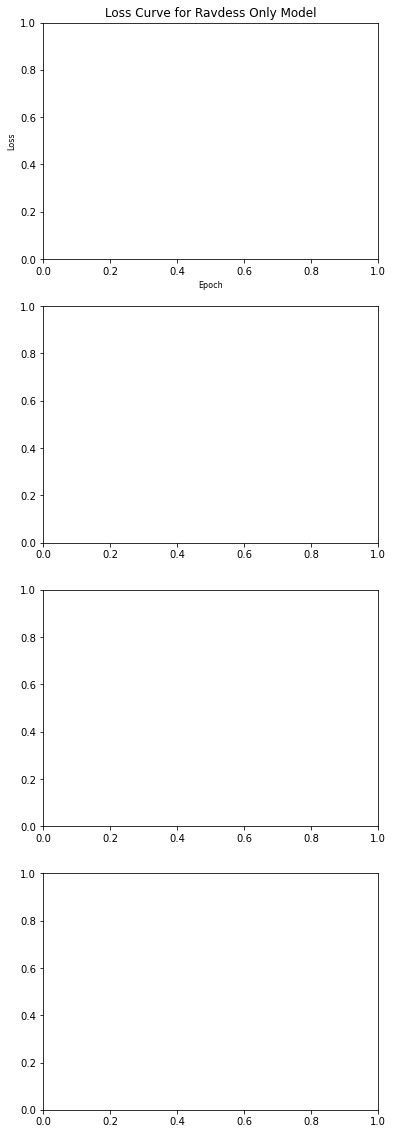

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(6,20))
ax[0].set_title('Loss Curve for Ravdess Only Model')
ax[0].set_ylabel('Loss', fontsize=8)
ax[0].set_xlabel('Epoch', fontsize=8)
ax[0].plot(train_losses_rav_only,'b')
ax[0].plot(valid_losses_rav_only,'r')
ax[0].legend(['Training loss','Validation loss'])

ax[1].set_title('Loss Curve for Iemocap Only Model')
ax[1].set_ylabel('Loss', fontsize=8)
ax[1].set_xlabel('Epoch', fontsize=8)
ax[1].plot(train_losses_iemo_only,'b')
ax[1].plot(valid_losses_iemo_only,'r')
ax[1].legend(['Training loss','Validation loss'])

ax[2].set_title('Loss Curve for Ravdess Train & Iemocap Val Model')
ax[2].set_ylabel('Loss', fontsize=8)
ax[2].set_xlabel('Epoch', fontsize=8)
ax[2].plot(train_losses_iemo_test,'b')
ax[2].plot(valid_losses_iemo_test,'r')
ax[2].legend(['Training loss','Validation loss'])

ax[3].set_title('Loss Curve for Iemocap Train & Ravdess Val Model')
ax[3].set_ylabel('Loss', fontsize=8)
ax[3].set_xlabel('Epoch', fontsize=8)
ax[3].plot(train_losses_rav_test,'b')
ax[3].plot(valid_losses_rav_test,'r')
ax[3].legend(['Training loss','Validation loss'])

plt.show()

# Load the Trained Model from Checkpoint for Evaluation

In [ ]:
# pick load folder  
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

if osx == 'mac':
    load_folder = 'checkpoints'
elif osx == 'windows':
    load_folder = 'checkpoints'

In [ ]:
## MODEL 1

# pick the epoch to load (429) default
model_name_1 = f'parallel_all_you_wantFINAL-RAV_ONLY.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name_1)

## instantiate empty model and populate with params from binary 
model_1 = parallel_all_you_want(num_labels)
load_checkpoint(optimizer, model_1, load_path)

print(f'Loaded model from {load_path}')

Loaded model from checkpoints\parallel_all_you_wantFINAL-RAV_ONLY.pkl


In [ ]:
## MODEL 2

# pick the epoch to load (429) default
model_name_2 = f'parallel_all_you_wantFINAL-IEMO_ONLY.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name_2)

## instantiate empty model and populate with params from binary 
model_2 = parallel_all_you_want(num_labels)
load_checkpoint(optimizer, model_2, load_path)

print(f'Loaded model from {load_path}')

Loaded model from checkpoints\parallel_all_you_wantFINAL-IEMO_ONLY.pkl


In [ ]:
## MODEL 3

# pick the epoch to load (429) default
model_name_3 = f'parallel_all_you_wantFINAL-IEMO_TEST.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name_3)

## instantiate empty model and populate with params from binary 
model_3 = parallel_all_you_want(num_labels)
load_checkpoint(optimizer, model_3, load_path)

print(f'Loaded model from {load_path}')

Loaded model from checkpoints\parallel_all_you_wantFINAL-IEMO_TEST.pkl


In [ ]:
## MODEL 4

# pick the epoch to load (429) default
model_name_4 = f'parallel_all_you_wantFINAL-RAV_TEST.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name_4)

## instantiate empty model and populate with params from binary 
model_4 = parallel_all_you_want(num_labels)
load_checkpoint(optimizer, model_4, load_path)

print(f'Loaded model from {load_path}')

Loaded model from checkpoints\parallel_all_you_wantFINAL-RAV_TEST.pkl


# Evaluate the Models on Hold-Out Test Set

In [ ]:
## MODEL 1 EVALUATE

# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model_1,criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor_rav_only = torch.tensor(X_test_rav_only).float()
# Convert 4D test label set array to tensor and move to GPU
y_test_tensor_rav_only = torch.tensor(y_test_rav_only,dtype=torch.long)

# Get the model's performance metrics using the validation function we defined
test_loss_rav_only, test_acc_rav_only, predicted_emotions_rav_only = validate(X_test_tensor_rav_only,y_test_tensor_rav_only)

In [ ]:
## MODEL 2 EVALUATE

# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model_2,criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor_iemo_only = torch.tensor(X_test_iemo_only).float()
# Convert 4D test label set array to tensor and move to GPU
y_test_tensor_iemo_only = torch.tensor(y_test_iemo_only,dtype=torch.long)

# Get the model's performance metrics using the validation function we defined
test_loss_iemo_only, test_acc_iemo_only, predicted_emotions_iemo_only = validate(X_test_tensor_iemo_only,y_test_tensor_iemo_only)

In [ ]:
## MODEL 3 EVALUATE

# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model_3,criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor_iemo_test = torch.tensor(X_test_iemo_test).float()
# Convert 4D test label set array to tensor and move to GPU
y_test_tensor_iemo_test = torch.tensor(y_test_iemo_test,dtype=torch.long)

# Get the model's performance metrics using the validation function we defined
test_loss_iemo_test, test_acc_iemo_test, predicted_emotions_iemo_test = validate(X_test_tensor_iemo_test,y_test_tensor_iemo_test)

In [ ]:
## MODEL 4 EVALUATE

# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model_4,criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor_rav_test = torch.tensor(X_test_rav_test).float()
# Convert 4D test label set array to tensor and move to GPU
y_test_tensor_rav_test = torch.tensor(y_test_rav_test,dtype=torch.long)

# Get the model's performance metrics using the validation function we defined
test_loss_rav_test, test_acc_rav_test, predicted_emotions_rav_test = validate(X_test_tensor_rav_test,y_test_tensor_rav_test)

In [ ]:
print(f'Test accuracy RAV ONLY is {test_acc_rav_only:.2f}%')
print()
print(f'Test accuracy IEMO ONLY is {test_acc_iemo_only:.2f}%')
print()
print(f'Test accuracy RAV TRAINING & IEMO TEST is {test_acc_iemo_test:.2f}%')
print()
print(f'Test accuracy IEMO TRAINING & RAV TEST is {test_acc_rav_test:.2f}%')

Test accuracy RAV ONLY is 98.53%

Test accuracy IEMO ONLY is 73.94%

Test accuracy RAV TRAINING & IEMO TEST is 38.85%

Test accuracy IEMO TRAINING & RAV TEST is 31.46%


# Analyze Performance on Test Set

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def conf_matrix(predicted_emotions, emotions_groundtruth, s):
    # because model tested on GPU, move prediction tensor to CPU then convert to array
    predicted_emotions = predicted_emotions.cpu().numpy()
    # use labels from test set

    # build confusion matrix and normalized confusion matrix
    conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
    conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

    # set labels for matrix axes from emotions
    emotion_names = ['neutral', 'happy', 'sad', 'angry']
          
    # make a confusion matrix with labels using a DataFrame
    confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
    confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

    # plot confusion matrices
    plt.figure(figsize=(16,6))
    sn.set(font_scale=1.8) # emotion label and title size
    plt.subplot(1,2,1)
    plt.title(s)
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
    plt.subplot(1,2,2)
    plt.title('Normalized '+s)
    sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

    plt.show()

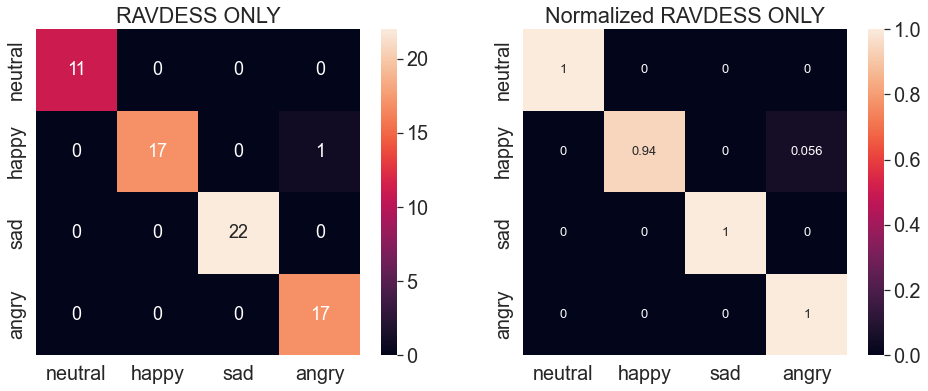

In [ ]:
conf_matrix(predicted_emotions_rav_only, y_test_rav_only, 'RAVDESS ONLY')

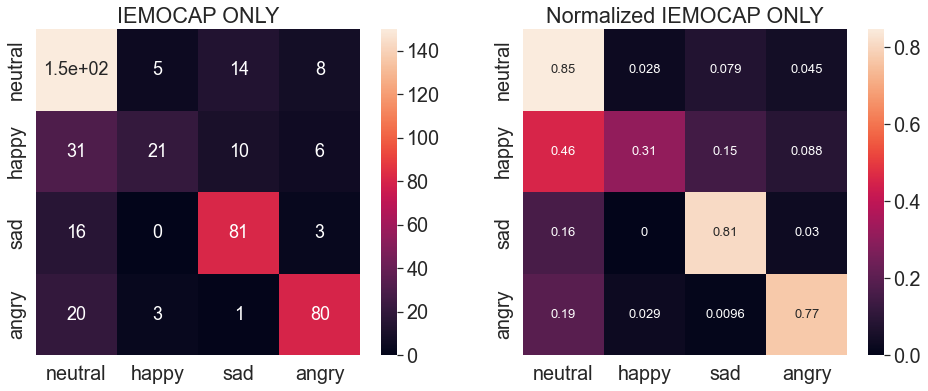

In [ ]:
conf_matrix(predicted_emotions_iemo_only, y_test_iemo_only, 'IEMOCAP ONLY')

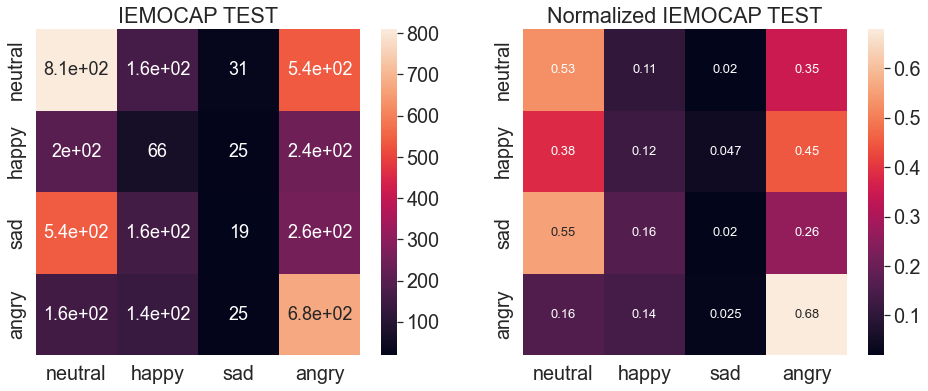

In [ ]:
conf_matrix(predicted_emotions_iemo_test, y_test_iemo_test, 'IEMOCAP TEST')

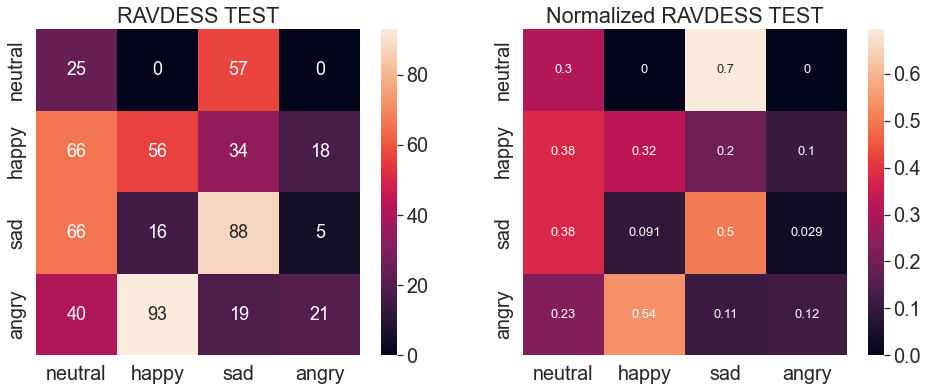

In [ ]:
conf_matrix(predicted_emotions_rav_test, y_test_rav_test, 'RAVDESS TEST')